https://www.kaggle.com/competitions/spaceship-titanic

## Introduction

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimensioTo help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

Help save them and change history!n!



In [65]:
import numpy as np
import pandas as pd 

In [66]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [67]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
submission_data = pd.read_csv("sample_submission.csv")

In [68]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [69]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [70]:
train_data.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

## Data preprocessing

In [71]:
def clean_data(df):
    # Rename columns
    rename_map = {
        'PassengerId': 'passenger_id', 'HomePlanet': 'home_planet', 
        'CryoSleep': 'cryo_sleep', 'Cabin': 'cabin', 
        'Destination': 'destination', 'Age': 'age',
        'VIP': 'vip', 'RoomService': 'room_service', 
        'FoodCourt': 'food_court', 'ShoppingMall': 'shopping_mall', 
        'Spa': 'spa', 'VRDeck': 'vr_deck', 'Name': 'name', 
        'Transported': 'transported'
    }
    df.rename(columns=rename_map, inplace=True)

    # Fill empty values
    mode_cols = ['home_planet', 'cryo_sleep', 'cabin', 'destination', 'vip']
    median_cols = ['age', 'room_service', 'food_court', 'shopping_mall', 'spa', 'vr_deck']
    
    for col in mode_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)
    for col in median_cols:
        df[col].fillna(df[col].median(), inplace=True)

    
    df[["deck", "num", "side"]] = df["cabin"].str.split("/", expand=True)
    df.drop(columns=["cabin", "passenger_id", "name"], inplace=True)

    # Encoding
    encode_cols = ['home_planet', 'cryo_sleep', 'destination', 'vip', 'deck', 'num', 'side']
    for col in encode_cols:
        df[col] = le.fit_transform(df[col].values)

    # Conversion
    int_cols = ['age', 'room_service', 'food_court', 'shopping_mall', 'spa', 'vr_deck']
    df[int_cols] = df[int_cols].astype(int)

    return df


In [72]:
# Apply process to raw data
le = LabelEncoder()
train_df = clean_data(train_data)
test_df = clean_data(test_data)

In [73]:
# Define training sample and target
X_train = train_df.drop(columns=["transported"])
y_train = train_df["transported"]

In [74]:
train_data.head(10)

,home_planet,cryo_sleep,destination,age,vip,room_service,food_court,shopping_mall,spa,vr_deck,transported,deck,num,side
0,1,0,2,39,0,0,0,0,0,0,False,1,0,0
1,0,0,2,24,0,109,9,25,549,44,True,5,0,1
2,1,0,2,58,1,43,3576,0,6715,49,False,0,0,1
3,1,0,2,33,0,0,1283,371,3329,193,False,0,0,1
4,0,0,2,16,0,303,70,151,565,2,True,5,1,1
5,0,0,1,44,0,0,483,0,291,0,True,5,0,0
6,0,0,2,26,0,42,1539,3,0,0,True,5,931,1
7,0,1,2,28,0,0,0,0,0,0,True,6,0,1
8,0,0,2,35,0,0,785,17,216,0,True,5,1042,1
9,1,1,0,14,0,0,0,0,0,0,True,1,1,0


## Data Visualization

In [116]:
df_corr = pd.DataFrame(train_df).corr()
df_corr.style.background_gradient(cmap='coolwarm', axis=None)

,home_planet,cryo_sleep,destination,age,vip,room_service,food_court,shopping_mall,spa,vr_deck,transported,deck,num,side
home_planet,1.000000,0.083586,0.034737,0.133577,0.123512,0.211751,0.071454,0.101383,0.055047,0.039824,0.115461,-0.404593,0.010726,0.000636
cryo_sleep,0.083586,1.000000,-0.096287,-0.071323,-0.078281,-0.244089,-0.205928,-0.207798,-0.198307,-0.192721,0.460132,0.020613,0.011922,0.023858
destination,0.034737,-0.096287,1.000000,-0.006771,-0.044707,0.045733,-0.111057,0.024721,-0.055815,-0.073293,-0.108152,0.180763,-0.019041,-0.012979
age,0.133577,-0.071323,-0.006771,1.000000,0.091863,0.068629,0.127390,0.033148,0.120946,0.099590,-0.074233,-0.239202,-0.000948,0.011621
vip,0.123512,-0.078281,-0.044707,0.091863,1.000000,0.056566,0.125499,0.018412,0.060991,0.123061,-0.037261,-0.176063,0.008129,-0.008798
room_service,0.211751,-0.244089,0.045733,0.068629,0.056566,1.000000,-0.015126,0.052337,0.009244,-0.018624,-0.241124,-0.021888,0.007080,-0.006991
food_court,0.071454,-0.205928,-0.111057,0.127390,0.125499,-0.015126,1.000000,-0.013717,0.221468,0.224572,0.045583,-0.315318,0.006709,0.019682
shopping_mall,0.101383,-0.207798,0.024721,0.033148,0.018412,0.052337,-0.013717,1.000000,0.014542,-0.007849,0.009391,-0.033577,-0.003939,-0.020940
spa,0.055047,-0.198307,-0.055815,0.120946,0.060991,0.009244,0.221468,0.014542,1.000000,0.147658,-0.218545,-0.214971,0.021997,0.005700
vr_deck,0.039824,-0.192721,-0.073293,0.099590,0.123061,-0.018624,0.224572,-0.007849,0.147658,1.000000,-0.204874,-0.251548,0.004951,-0.009089


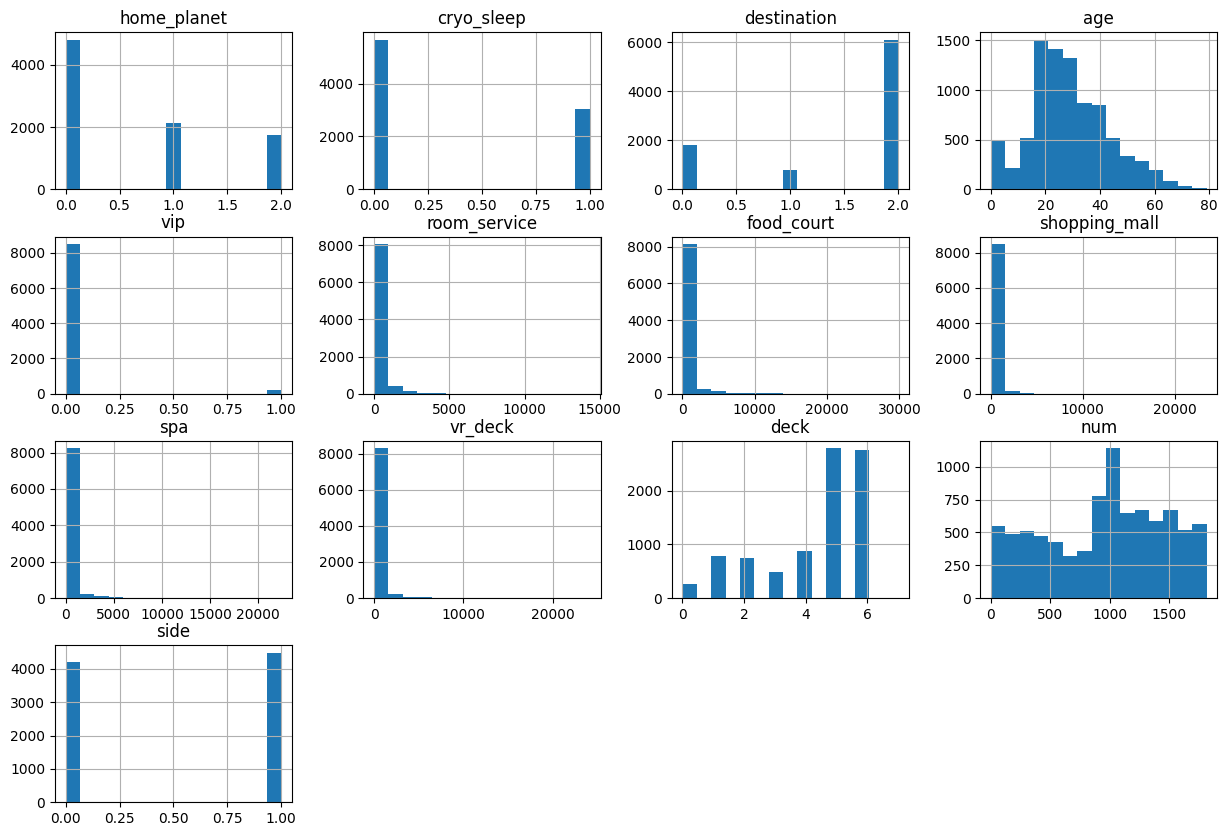

In [77]:

import matplotlib.pyplot as plt
import seaborn as sns

# Histogrammes pour les variables numériques
train_df.hist(bins=15, figsize=(15, 10))
plt.show()


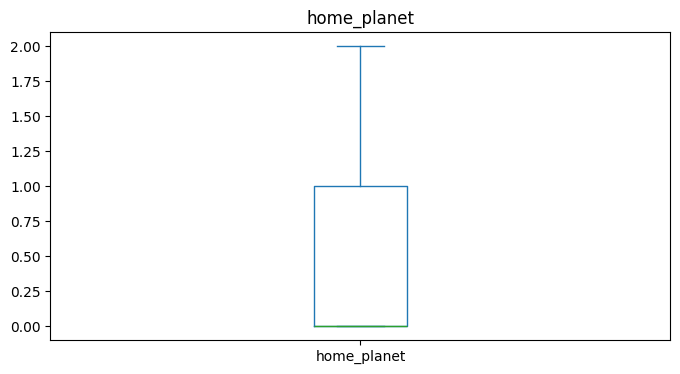

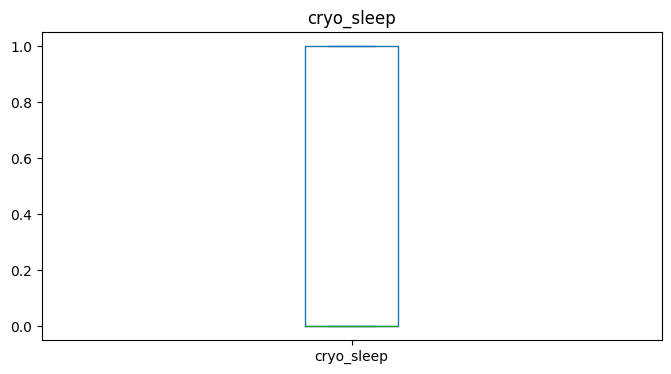

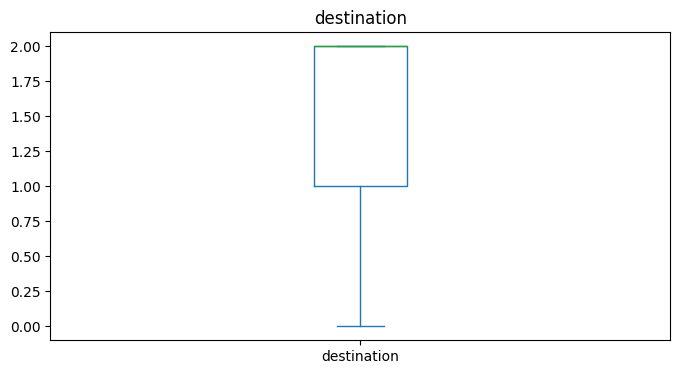

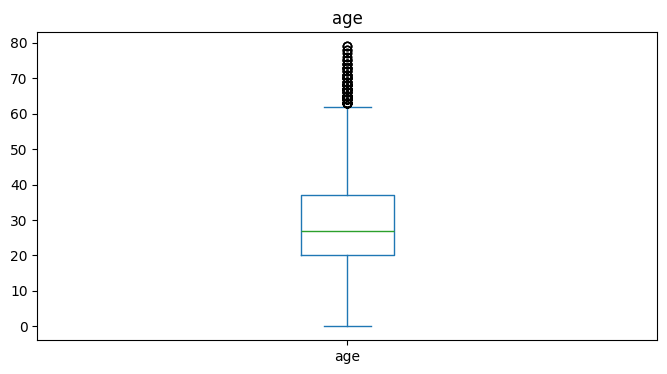

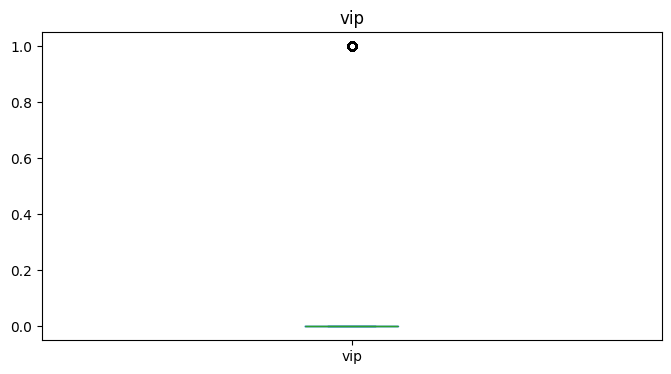

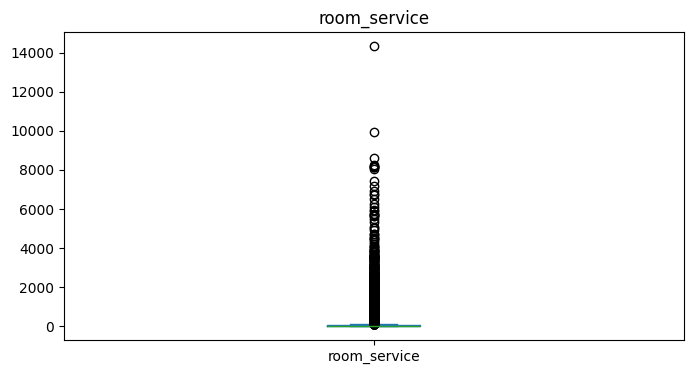

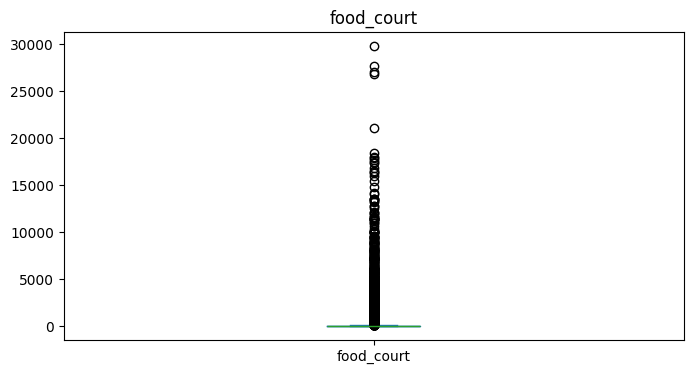

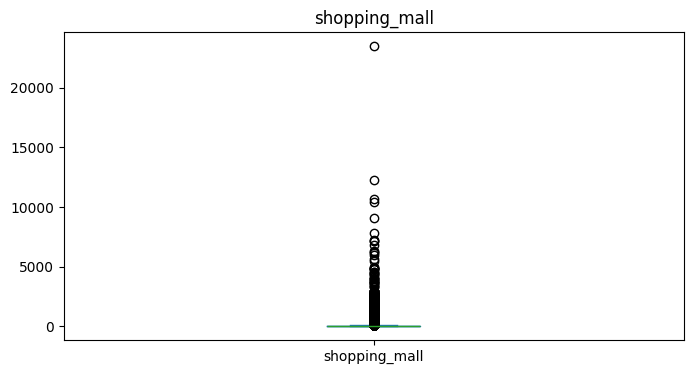

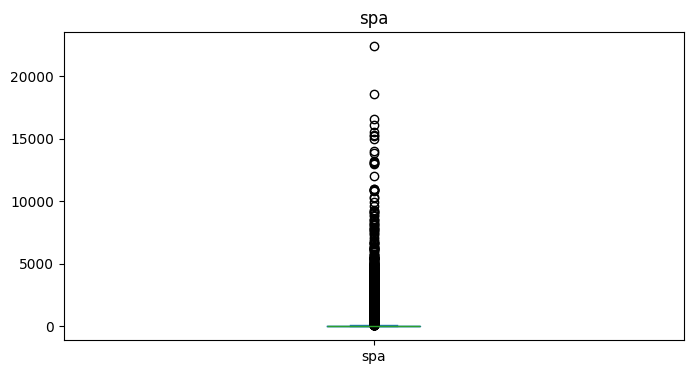

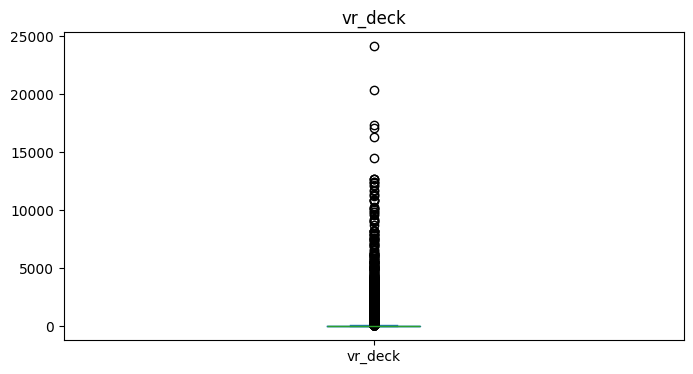

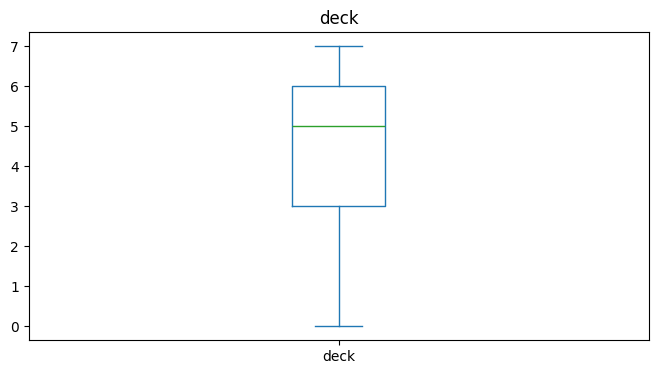

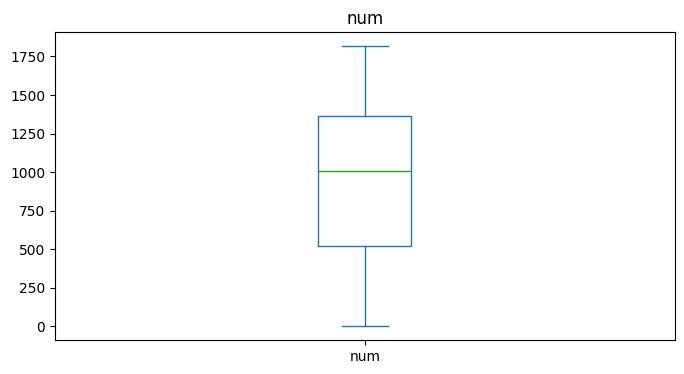

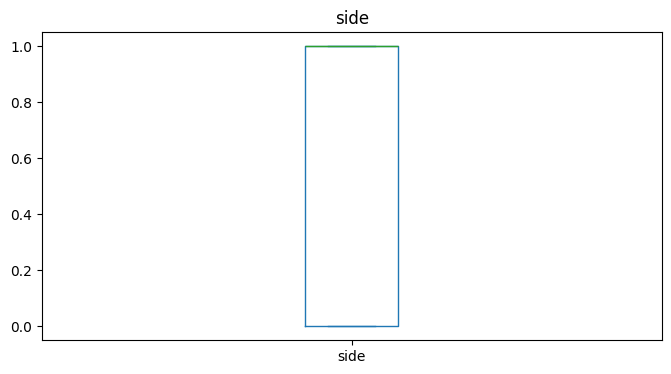

In [118]:
import matplotlib.pyplot as plt

# Tracer un boxplot pour chaque colonne numérique individuellement
for col in num_cols:
    plt.figure(figsize=(8, 4))
    train_df[col].plot(kind='box')
    plt.title(col)
    plt.show()



## Model Selection with GridSearch

In [119]:
#Splitting data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [120]:
# Normalize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [83]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


models = {
    'RandomForest': RandomForestClassifier(),
    'SVC': SVC(),
    'XGBClassifier': XGBClassifier()
}

params = {
    'RandomForest': {
        'min_samples_split': [0.001, 0.005],
        'max_depth': [16, 32,],
        'n_estimators': [100, 500]
    },
    'SVC': {'C': [0.1, 1, 10]},
    'XGBClassifier': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
}

for model_name, model in models.items():
    grid = GridSearchCV(model, params[model_name], cv=5)
    grid.fit(X_train, y_train)
    print(f"Best parameters for {model_name}: {grid.best_params_}")
    print(f"Best score for {model_name}: {grid.best_score_}")
n_estimators=500,max_depth=32,min_samples_split=0.005)

Best parameters for RandomForest: {'max_depth': 16, 'min_samples_split': 0.001, 'n_estimators': 500}
Best score for RandomForest: 0.8073055459298988
Best parameters for SVC: {'C': 1}
Best score for SVC: 0.8016986899337468
Best parameters for XGBClassifier: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best score for XGBClassifier: 0.806586431789148


In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(verbosity=1, random_state=42)


param_grid = {
    'n_estimators': [50, 80, 100],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [3, 4, 5]
}


grid_xg = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,  
    scoring='accuracy',  
    verbose=2
)


grid_xg.fit(X_train, y_train, eval_set=[(X_val, y_val)])

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[0]	validation_0-logloss:0.67807
[1]	validation_0-logloss:0.66409
[2]	validation_0-logloss:0.65166
[3]	validation_0-logloss:0.64009
[4]	validation_0-logloss:0.62954
[5]	validation_0-logloss:0.61908
[6]	validation_0-logloss:0.61014
[7]	validation_0-logloss:0.60180
[8]	validation_0-logloss:0.59381
[9]	validation_0-logloss:0.58635
[10]	validation_0-logloss:0.57943
[11]	validation_0-logloss:0.57272
[12]	validation_0-logloss:0.56629
[13]	validation_0-logloss:0.56076
[14]	validation_0-logloss:0.55527
[15]	validation_0-logloss:0.55034
[16]	validation_0-logloss:0.54573
[17]	validation_0-logloss:0.54153
[18]	validation_0-logloss:0.53726
[19]	validation_0-logloss:0.53349
[20]	validation_0-logloss:0.52964
[21]	validation_0-logloss:0.52629
[22]	validation_0-logloss:0.52289
[23]	validation_0-logloss:0.52023
[24]	validation_0-logloss:0.51725
[25]	validation_0-logloss:0.51374
[26]	validation_0-logloss:0.51053
[27]	validation_0-logloss:0.507

In [88]:
print("Meilleurs paramètres trouvés: ", grid_xg.best_params_)

Meilleurs paramètres trouvés:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [100]:
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, verbosity=0, random_state= 42)
xgb_model.fit(X_train,y_train, eval_set=[(X_val,y_val)])

[0]	validation_0-logloss:0.66342
[1]	validation_0-logloss:0.63840
[2]	validation_0-logloss:0.61754
[3]	validation_0-logloss:0.59957
[4]	validation_0-logloss:0.58436
[5]	validation_0-logloss:0.57035
[6]	validation_0-logloss:0.55897
[7]	validation_0-logloss:0.54978
[8]	validation_0-logloss:0.54072
[9]	validation_0-logloss:0.53258
[10]	validation_0-logloss:0.52580
[11]	validation_0-logloss:0.51915
[12]	validation_0-logloss:0.51205
[13]	validation_0-logloss:0.50676
[14]	validation_0-logloss:0.50152
[15]	validation_0-logloss:0.49688
[16]	validation_0-logloss:0.49181
[17]	validation_0-logloss:0.48779
[18]	validation_0-logloss:0.48494
[19]	validation_0-logloss:0.48126
[20]	validation_0-logloss:0.47813
[21]	validation_0-logloss:0.47552
[22]	validation_0-logloss:0.47376
[23]	validation_0-logloss:0.47117
[24]	validation_0-logloss:0.46897
[25]	validation_0-logloss:0.46710
[26]	validation_0-logloss:0.46528
[27]	validation_0-logloss:0.46354
[28]	validation_0-logloss:0.46218
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [101]:
acc_train = accuracy_score(xgb_model.predict(X_train),y_train)
acc_val = accuracy_score(xgb_model.predict(X_val),y_val)
print(f"Metrics train:\n\tAccuracy score: {acc_train:.4f}\nMetrics validation:\n\tAccuracy score:{acc_val:.4f}")

Metrics train:
	Accuracy score: 0.8181
Metrics validation:
	Accuracy score:0.7878


In [92]:
random_forest_model = RandomForestClassifier(n_estimators=500,max_depth=16,min_samples_split=0.005).fit(X_train,y_train)
acc_train = accuracy_score(random_forest_model.predict(X_train),y_train)
acc_val = accuracy_score(random_forest_model.predict(X_val),y_val)
print(f"train accuracy: {acc_train:.4f}\nval accuracy:{acc_val:.4f}")

train accuracy: 0.8607
val accuracy:0.7907


**Model Selection:**

We chose `XGBoost` for its stronger generalization capabilities, as indicated by its closer training and validation accuracies (0.8158 and 0.7826, respectively). Unlike other models, which show a significant discrepancy between training and validation performance, `XGBoost`'s smaller gap suggests it is more reliable for real-world applications due to its reduced likelihood of overfitting.


## Neural Network Model with TensorFlow (Simple Model)

In [32]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(50, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

# Entraînement du modèle
model.fit(X_train, y_train, epochs=30, batch_size=64)


Epoch 1/30
136/136 [==============================] - 1s 2ms/step - loss: 3.2233 - accuracy: 0.6780
Epoch 2/30
136/136 [==============================] - 0s 1ms/step - loss: 1.0207 - accuracy: 0.7059
Epoch 3/30
136/136 [==============================] - 0s 1ms/step - loss: 0.8310 - accuracy: 0.6547
Epoch 4/30
136/136 [==============================] - 0s 1ms/step - loss: 0.6495 - accuracy: 0.6123
Epoch 5/30
136/136 [==============================] - 0s 1ms/step - loss: 0.5896 - accuracy: 0.7359
Epoch 6/30
136/136 [==============================] - 0s 2ms/step - loss: 0.6641 - accuracy: 0.5579
Epoch 7/30
136/136 [==============================] - 0s 2ms/step - loss: 0.6057 - accuracy: 0.6819
Epoch 8/30
136/136 [==============================] - 0s 2ms/step - loss: 0.5577 - accuracy: 0.7616
Epoch 9/30
136/136 [==============================] - 0s 2ms/step - loss: 0.5459 - accuracy: 0.7662
Epoch 10/30
136/136 [==============================] - 0s 1ms/step - loss: 0.5381 - accuracy: 0.7505

## Predictions

In [106]:
test_df = scaler.transform(test_df)

In [111]:
predictions = xgb_model.predict(test_df)
submission_data["Transported"] = predictions
submission_data["Transported"] = submission_data["Transported"].replace({0: False, 1: True})


In [112]:
submission_data["Transported"]

0        True
1       False
2        True
3        True
4        True
        ...  
4272     True
4273    False
4274     True
4275     True
4276     True
Name: Transported, Length: 4277, dtype: bool

In [113]:
submission_data

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [114]:
submission_data.to_csv('submission.csv', index=False)